In [1]:
# LIBRARY:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

import statsmodels as sa

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline
%matplotlib nbagg

%cd /Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES/

/Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES


In [17]:
# Import dataset:

df = pd.read_csv('GTEX-ALL_SAMPLES.v8.phASER.gw_phased.results.fdr_ALL.gene_info.zscores.txt', sep='\t')

# add column for GENE_IDs without version #:
df[['GENE_ID','ens_version']] = df['GENE_ID'].str.split('.',expand=True)

df.head()

/Users/snkravitz/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,mean_read_counts,total_sample_count_females,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,ens_version
0,1,ENSG00000228794,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,58.0,133.0,NaN,414,74.0,0.178744,0.315991,private_RME,8
1,1,ENSG00000223764,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,38.0,173.0,NaN,492,132.0,0.268293,0.915775,private_RME,2
2,1,ENSG00000188976,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,178.0,179.0,NaN,532,48.0,0.090226,-0.276891,private_RME,10
3,1,ENSG00000187961,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,24.0,160.0,NaN,473,34.0,0.071882,-0.399756,private_RME,13
4,1,ENSG00000187583,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,96.0,194.0,NaN,566,47.0,0.083039,-0.325026,private_RME,10


In [18]:
## Filter out X-Chr genes, Imprinted genes, and HLA genes:

# Remove X-Chr:
df = df[df['CHR'] != 'X']

# Remove HLA genes:
df = df[~df['GENE_NAME'].str.contains("HLA")]

# Remove Imprinted Genes:
imprinted_df = pd.read_csv("~/Documents/Gene_Lists/GTEx_Imprinting/GTEx_Imprinted_Table_S3andS4.uniq.txt", sep=' ', names=['GENE_ID', 'chrom', 'start'])
imprinted_genes = list(imprinted_df['GENE_ID'])
imprinted_genes
df = df[~df['GENE_ID'].isin(imprinted_genes)]

In [19]:
# Drop duplicate rows:

df = df[['CHR', 'GENE_ID', 'GENE_NAME', 'z_score']].dropna().drop_duplicates(subset=['GENE_ID'])

df.shape

(23481, 4)

In [20]:
df.head()

,CHR,GENE_ID,GENE_NAME,z_score
0,1,ENSG00000228794,LINC01128,0.315991
1,1,ENSG00000223764,RP11-54O7.3,0.915775
2,1,ENSG00000188976,NOC2L,-0.276891
3,1,ENSG00000187961,KLHL17,-0.399756
4,1,ENSG00000187583,PLEKHN1,-0.325026


In [21]:
## Get median # of eQTLs per Gene:

df_eqtls = pd.read_csv('/Users/snkravitz/Documents/Projects_and_Data/GTEx_v8_eQTLs/GTEx_v8_eQTLs_allTissues.counts.txt.gz', compression='gzip', sep='\t')
df_eqtls.head()


,pid,tissue,sid
0,ENSG00000000003.14,Adipose_Subcutaneous,100
1,ENSG00000000003.14,Adipose_Visceral_Omentum,67
2,ENSG00000000003.14,Artery_Aorta,51
3,ENSG00000000003.14,Artery_Coronary,3
4,ENSG00000000003.14,Artery_Tibial,58


In [22]:
## Get median # of eQTLs per Gene:

df_eqtl_meds = df_eqtls.groupby('pid')['sid'].median().astype(int).to_frame().reset_index()
df_eqtl_meds['GENE_ID'] = df_eqtl_meds['pid'].str.split('.', expand=True)[0]
df_eqtl_meds.head()

,pid,sid,GENE_ID
0,ENSG00000000003.14,42,ENSG00000000003
1,ENSG00000000005.5,21,ENSG00000000005
2,ENSG00000000419.12,3,ENSG00000000419
3,ENSG00000000457.13,111,ENSG00000000457
4,ENSG00000000460.16,100,ENSG00000000460


In [41]:
## EDIT 210907: get median # of eQTLs controlled by gene expression:

## First get the median TPM across tissues (from GTEx data downloads):
gene_tpms = pd.read_csv('/Users/snkravitz/Documents/GTEx_Summary_Data/GTEx_v8_StudyFiles/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct', sep='\t')
gene_tpms.head()

# Get median TPM across all tissues:
med_tpms = gene_tpms.set_index(['Name', 'Description']).median(axis=1).to_frame()
med_tpms.reset_index(inplace=True)
med_tpms.rename(columns={0:'med_tpm', 'Name':'GENE_ID'}, inplace=True)
# add column for GENE_IDs without version #:
med_tpms[['GENE_ID','ens_version']] = med_tpms['GENE_ID'].str.split('.',expand=True)

med_tpms.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/snkravitz/Documents/GTEx_Summary_Data/GTEx_v8_StudyFiles/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct'

In [23]:
## First get the median TPM across tissues (from GTEx data downloads):
med_tpms = pd.read_csv('/Users/snkravitz/Documents/GTEx_Summary_Data/GTEx_v8_StudyFiles/GTEx.v8.all-tissues.gene_median_tpm.info.txt', sep='\t')
med_tpms[['GENE_ID','ens_version']] = med_tpms['GENE_ID'].str.split('.',expand=True)
med_tpms.head()

,GENE_ID,GENE_NAME,median_tpms,num_tissues_expressed,ens_version
0,ENSG00000000003,TSPAN6,9.527640,56,14
1,ENSG00000000005,TNMD,0.201407,50,5
2,ENSG00000000419,DPM1,50.049600,56,12
3,ENSG00000000457,SCYL3,6.007240,56,13
4,ENSG00000000460,C1orf112,1.973760,56,16


In [25]:
## Normalize median eQTL # by gene expression med_tpms: 

df_eqtl_meds = df_eqtl_meds.merge(med_tpms[['GENE_ID', 'median_tpms']], how='left', on='GENE_ID')

df_eqtl_meds['sid_norm'] = df_eqtl_meds['sid'] / (df_eqtl_meds['median_tpms'] + 1)

df_eqtl_meds.head()

,pid,sid,GENE_ID,median_tpms,sid_norm
0,ENSG00000000003.14,42,ENSG00000000003,9.527640,3.989498
1,ENSG00000000005.5,21,ENSG00000000005,0.201407,17.479505
2,ENSG00000000419.12,3,ENSG00000000419,50.049600,0.058766
3,ENSG00000000457.13,111,ENSG00000000457,6.007240,15.840759
4,ENSG00000000460.16,100,ENSG00000000460,1.973760,33.627462


In [26]:
# Merge Z-score to median # of eQTLs per gene:

df_eqtl_meds = df_eqtl_meds.merge(df[['GENE_ID', 'z_score']], how='inner', on='GENE_ID')
df_eqtl_meds.head()

,pid,sid,GENE_ID,median_tpms,sid_norm,z_score
0,ENSG00000000419.12,3,ENSG00000000419,50.04960,0.058766,-0.619828
1,ENSG00000000457.13,111,ENSG00000000457,6.00724,15.840759,-0.149095
2,ENSG00000000460.16,100,ENSG00000000460,1.97376,33.627462,1.860492
3,ENSG00000000938.12,12,ENSG00000000938,6.13408,1.682067,-0.729558
4,ENSG00000000971.15,129,ENSG00000000971,24.34690,5.089380,2.340941


In [24]:
## Optional: Subset only protein-coding genes: 

protein_coding = pd.read_csv('~/Documents/Projects_and_Data/GTEx_HaplotypeExpression/GeneHancer_analyses/GTEX-ALL_SAMPLES.v8.all-tissues.gene_info.zscores.proteincoding.final.txt', sep='\t')
print(protein_coding.head())

protein_coding_genes = np.array(protein_coding['GENE_ID'])

df_eqtl_meds = df_eqtl_meds.loc[df_eqtl_meds['pid'].isin(protein_coding_genes)]

print(df_eqtl_meds.shape)
df_eqtl_meds.head()


  CHR       GENE_ID.v2             GENE_ID GENE_NAME  gene_start  gene_stop  \
0   1  ENSG00000188976  ENSG00000188976.10     NOC2L      944581     959309   
1   1  ENSG00000187961  ENSG00000187961.13    KLHL17      960586     965715   
2   1  ENSG00000187583  ENSG00000187583.10   PLEKHN1      966496     975108   
3   1  ENSG00000131591  ENSG00000131591.17  C1orf159     1081817    1116361   
4   1  ENSG00000078808  ENSG00000078808.16      SDF4     1216907    1232031   

   total_sample_count   z_score  
0                 532 -0.276891  
1                 473 -0.399756  
2                 566 -0.325026  
3                 638 -0.377295  
4                 626 -0.068051  
(16010, 7)


,pid,sid,GENE_ID,med_tpm,sid_norm,z_score,mosaic_category
0,ENSG00000000419.12,3,ENSG00000000419,50.04960,0.058766,-0.619828,Biallelic
1,ENSG00000000457.13,111,ENSG00000000457,6.00724,15.840759,-0.149095,Biallelic
2,ENSG00000000460.16,100,ENSG00000000460,1.97376,33.627462,1.860492,RME
3,ENSG00000000938.12,12,ENSG00000000938,6.13408,1.682067,-0.729558,Biallelic
4,ENSG00000000971.15,129,ENSG00000000971,24.34690,5.089380,2.340941,RME


In [166]:
## Plotting z-score vs. median eQTLs:

# Get deciles of median eQTL #:
## Where the deciles are based on the RANGE of median # eQTLs (therefore the bins will not have equal # of genes)

uniq_counts = df_eqtl_meds['sid'].unique()

pctiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

pctile_counts = []
for p in pctiles:
    pctile_counts.append(np.percentile(uniq_counts, p, interpolation='nearest'))
    
print(pctile_counts)

# Subset df by mean read counts (deciles):
eqtl_dfs = []
for index, p in enumerate(pctile_counts[0:len(pctile_counts)-1]):
    lower = p
    upper = pctile_counts[index + 1]
    df_subset = df_eqtl_meds[df_eqtl_meds['sid'].between(lower, upper)]
    df_subset[['percentile']] = (index + 1) * 10
    eqtl_dfs.append(df_subset)

df_pctile_vals = pd.concat(eqtl_dfs, ignore_index=True)
df_pctile_vals.head()

# merge percentiles with original df:
#df_eqtls = df_eqtl_meds.merge(df_pctile_vals['percentile'], left_index=True, right_index=True)
#df_eqtls.head()

[1, 80, 158, 237, 316, 396, 482, 583, 750, 1170, 3971]


<ipython-input-166-0c44a3af0860>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[['percentile']] = (index + 1) * 10
/Users/snkravitz/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-166-0c44a3af0860>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,pid,sid,GENE_ID,z_score,percentile
0,ENSG00000000419.12,3,ENSG00000000419,-0.619828,10
1,ENSG00000000938.12,12,ENSG00000000938,-0.729558,10
2,ENSG00000001036.13,27,ENSG00000001036,-0.154310,10
3,ENSG00000001084.10,20,ENSG00000001084,-0.057183,10
4,ENSG00000001461.16,64,ENSG00000001461,0.163500,10


<IPython.core.display.Javascript object>


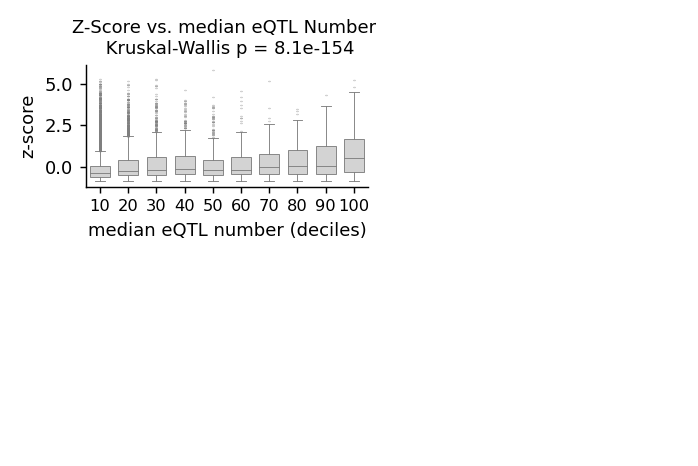

In [168]:
# Plot Z-Score vs. eQTL Number (decile)
f, ax = plt.subplots(figsize=(3,2), tight_layout=True)
sns.despine()

#anova_p = stats.f_oneway(*(df_pctile_vals[df_pctile_vals['percentile'] == p]['z_score'].dropna() for p in np.linspace(10, 100, 10).astype(int)))
kruskal_p = stats.kruskal(*(df_pctile_vals[df_pctile_vals['percentile'] == p]['z_score'].dropna() for p in np.linspace(10, 100, 10).astype(int)))

ax = sns.boxplot(data=df_pctile_vals, x = 'percentile', y = 'z_score', linewidth=0.5, fliersize=0.1, width=0.7, color="lightgray")
ax.set_xlabel('median eQTL number (deciles)', fontsize=10)
ax.set_ylabel('z-score', fontsize=10)
ax.set_xticklabels(np.linspace(10, 100, 10).astype(int), size=9)
ax.set_title('Z-Score vs. median eQTL Number \n Kruskal-Wallis p = %.2g' % kruskal_p.pvalue, fontsize=10)

#plt.show()

#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.eQTL_decile.vs.z-score.pdf', transparent=True)


In [169]:
## Plotting Z-Scores vs. eQTL #:

# Get deciles of eQTL num:
## Where the deciles are EVENLY binned, i.e. sort the data by median eQTL #, and slice evenly

df_eqtls = df_eqtl_meds.sort_values(by='sid').reset_index()

eqtl_bins = np.linspace(0,df_eqtls.shape[0], 20).astype(int)
print(eqtl_bins)

# Subset df by median eQTL # (deciles):
eqtl_deciles = []
for index, p in enumerate(eqtl_bins[0:len(eqtl_bins)-1]):
    lower = p
    upper = eqtl_bins[index + 1]
    df_subset = df_eqtls.iloc[lower:upper]
    #df_subset = df['data_qvalues'][df['mean_read_counts'].between(lower, upper)].to_frame()
    df_subset['percentile'] = (index + 1) * 5
    eqtl_deciles.append(df_subset)
    
df_pctile_vals = pd.concat(eqtl_deciles, ignore_index=True)
df_pctile_vals.head()

[    0  1201  2402  3604  4805  6007  7208  8410  9611 10813 12014 13216
 14417 15619 16820 18022 19223 20425 21626 22828]


<ipython-input-169-9618eda2ccc9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['percentile'] = (index + 1) * 5


,index,pid,sid,GENE_ID,z_score,percentile
0,10860,ENSG00000167654.17,1,ENSG00000167654,-0.633139,5
1,5665,ENSG00000130749.9,1,ENSG00000130749,-0.470297,5
2,1613,ENSG00000088247.17,1,ENSG00000088247,-0.552549,5
3,21612,ENSG00000272256.1,1,ENSG00000272256,-0.114587,5
4,5652,ENSG00000130711.3,1,ENSG00000130711,0.458361,5


<IPython.core.display.Javascript object>


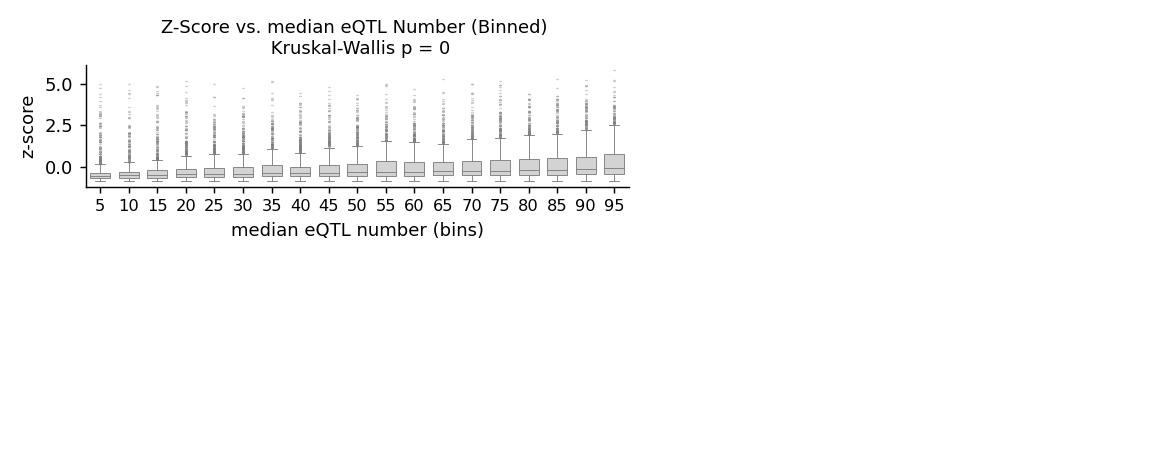

In [171]:
# Plot Z-Score vs. median eQTL # (bins)
f, ax = plt.subplots(figsize=(5,2), tight_layout=True)
sns.despine()

#anova_p = stats.f_oneway(*(df_pctile_vals[df_pctile_vals['percentile'] == p]['z_score'].dropna() for p in np.linspace(5,95, 19)))
kruskal_p = stats.kruskal(*(df_pctile_vals[df_pctile_vals['percentile'] == p]['z_score'].dropna() for p in np.linspace(5,95, 19)))

ax = sns.boxplot(data=df_pctile_vals, x = 'percentile', y = 'z_score', linewidth=0.5, fliersize=0.1, width=0.7, color="lightgray")
ax.set_xlabel('median eQTL number (bins)', fontsize=10)
ax.set_ylabel('z-score', fontsize=10)
ax.set_xticklabels(np.linspace(5,95, 19).astype(int), size=9)
ax.set_title('Z-Score vs. median eQTL Number (Binned) \n Kruskal-Wallis p = %.2g' % kruskal_p.pvalue, fontsize=10)
             
#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.eQTL_bins.vs.z-score.pdf', transparent=True)

<IPython.core.display.Javascript object>


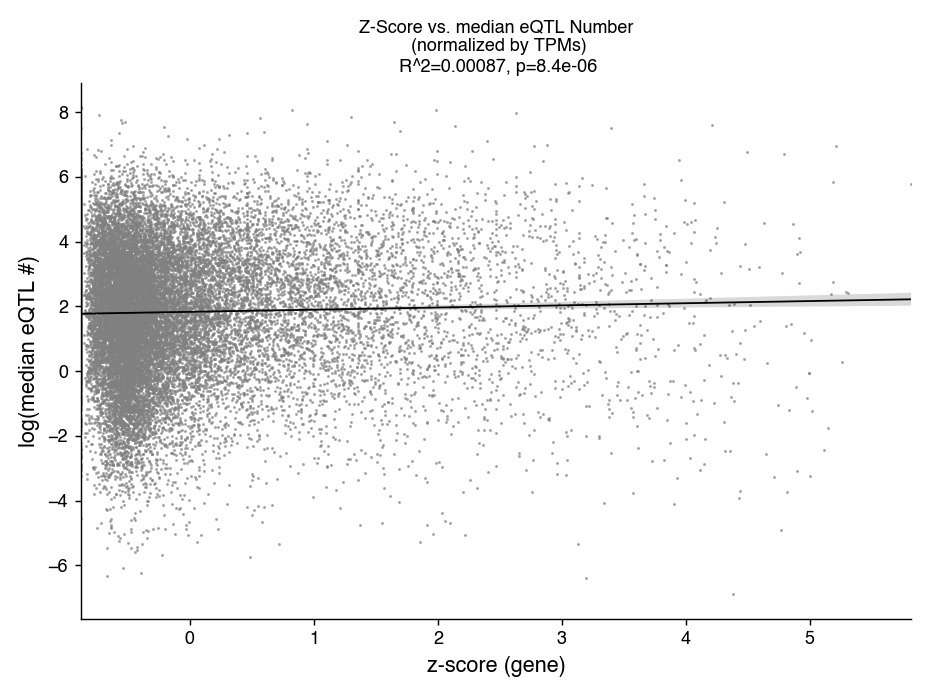

Text(0.5, 1.0, 'Z-Score vs. median eQTL Number\n (normalized by TPMs)\n R^2=0.00087, p=8.4e-06')

In [27]:
f, ax = plt.subplots(figsize=(4,3), tight_layout=True)
sns.despine()

slope, intercept, r_value, p_value, std_err = stats.linregress(df_eqtl_meds['z_score'], np.log(df_eqtl_meds['sid_norm']))
r_squared = r_value ** 2 

ax = sns.regplot(data=df_eqtl_meds, x=df_eqtl_meds['z_score'], y=np.log(df_eqtl_meds['sid_norm']), fit_reg=True, truncate=True, ci=95, scatter_kws={"color":"grey", "s": 0.5, "alpha": 0.6, 'rasterized': True}, line_kws={"color":"black", "lw":1}, y_jitter=0.1)
ax.set_xlabel('z-score (gene)', fontsize=12, fontweight='light')
ax.set_ylabel('log(median eQTL #)', fontsize=12, fontweight='light')
ax.set_title('Z-Score vs. median eQTL Number\n (normalized by TPMs)\n R^2={0:.2g}, p={1:.2g}'.format(r_squared,p_value), fontsize=10)
#ax.set_ylim(0, 8)
#ax.text(4, 6, "r={0:.1f}, p={1:.1f}".format(r_value,p_value), horizontalalignment='left', size='medium', color='black') #, weight='semibold')
#ax.legend()

#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.protein-coding.eQTL.vs.z-score_regplot.TPM-normalized.pdf', dpi=400, transparent=True)


In [33]:
df_eqtl_meds['sid_norm'].describe

<bound method NDFrame.describe of 0          0.766672
1         61.908612
2        147.071724
3          6.615725
4         40.408413
            ...    
22817     12.146720
22819     -5.064919
22820    -52.690372
22822     -1.025158
22825   -137.869535
Name: sid_norm, Length: 16010, dtype: float64>

In [28]:
## Subset RME and Biallelic genes (and 'Unknown'):

df_eqtl_meds['mosaic_category'] = np.where(df_eqtl_meds['z_score'] >= 0.74, 'RME', 'Unknown')
df_eqtl_meds['mosaic_category'] = np.where(df_eqtl_meds['z_score'] < 0, 'Biallelic', df_eqtl_meds['mosaic_category'])

df_eqtl_meds.head()

,pid,sid,GENE_ID,median_tpms,sid_norm,z_score,mosaic_category
0,ENSG00000000419.12,3,ENSG00000000419,50.04960,0.058766,-0.619828,Biallelic
1,ENSG00000000457.13,111,ENSG00000000457,6.00724,15.840759,-0.149095,Biallelic
2,ENSG00000000460.16,100,ENSG00000000460,1.97376,33.627462,1.860492,RME
3,ENSG00000000938.12,12,ENSG00000000938,6.13408,1.682067,-0.729558,Biallelic
4,ENSG00000000971.15,129,ENSG00000000971,24.34690,5.089380,2.340941,RME


<IPython.core.display.Javascript object>


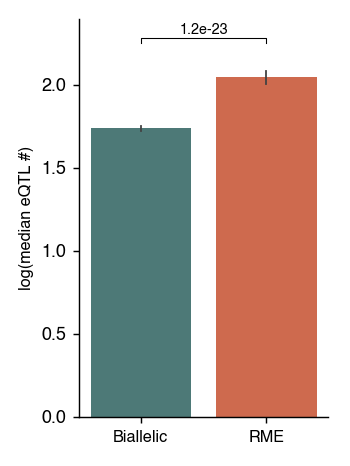

In [37]:
## Plot boxplot of Biallelic vs. RME genes for median TPMs:

f, ax = plt.subplots(figsize=(1.5, 2), tight_layout=True)
sns.despine()

#kw_pval = stats.kruskal(np.array(df_eqtl_meds.loc[df_eqtl_meds['mosaic_category'] == 'RME', 'sid']), np.array(df_eqtl_meds.loc[df_eqtl_meds['mosaic_category'] == 'Biallelic', 'sid']), nan_policy='omit') ## np.array(df.loc[df['mosaic_category'] == 'X-Chr.', 'mappability']), 
f_oneway = stats.f_oneway(df_eqtl_meds[df_eqtl_meds['mosaic_category'] == 'Biallelic']['sid_norm'], df_eqtl_meds[df_eqtl_meds['mosaic_category'] == 'RME']['sid_norm'])


ax = sns.barplot(x=df_eqtl_meds['mosaic_category'], y=np.log(df_eqtl_meds['sid_norm']), data=df_eqtl_meds[df_eqtl_meds['mosaic_category'] != 'Unknown'], order=["Biallelic", "RME"], palette=["#46807D","#E35E39"], ci=68, errwidth=1)
ax.plot([0, 0, 1, 1], [2.25, 2.28, 2.28, 2.25], lw=0.6, c='k')
ax.text(0.5, 2.285, "%.2g" % f_oneway.pvalue, ha='center', va='bottom', color='k', fontsize=8)
ax.set_ylabel("log(median eQTL #)", fontsize=9, fontweight='light')
ax.set_xlabel("")
ax.set_xticklabels(['Biallelic', 'RME'], fontsize=9, fontweight='light')

plt.show()

#plt.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.protein-coding.eQTL.vs.z-score_barplot.TPM-normalized.ci68.pdf', transparent=True)


In [31]:
f_oneway

F_onewayResult(statistic=100.79571391200967, pvalue=1.1657634973489286e-23)